**Instructions**  
1. pip install tdqm  because this is required for the progress bar built into the train() and make_conf_matrix() functions. 

2. Create test set dataloader

3. Load model and pre-trained weights (no training in this code) 

4. Run SHAP experiments on random (or index defined) testset images

This code is original apart from where marked "(see ref above)", which refers to: https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

In [1]:
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tqdm.notebook import tqdm # may need to pip install tqdm to get progress bar

In [2]:
from utils import *
from models import *
from dataset import *

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')
print(device)

cuda


In [4]:
#create test dataloader only because this notebook is for LIME only
testset = FER2013Dataset('data/test.csv')
torch.backends.cudnn.benchmark = True
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=0, pin_memory = True, drop_last = True)

In [5]:
labels = testset.classes # get the labels from the testset
labels=np.array(labels).reshape(1,7) # convert to np array and reshape so it works with SHAP

**Load pre-trained CNN model**

In [6]:
# #create VGG face fer network 
net = Vgg_vd_face_fer_dag()

# Then amend network shape to make it suitable for 1 channel input (it already has 7 outputs). 

# Load the weights from the best MK trained model

net.conv1_1 = nn.Conv2d(1, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)) 
load_checkpoint('FER_Model__Final_Weights.pth', net, device)
#proceed directly to evaluation


Model's pretrained weights loaded!


In [7]:
#send net to device and set to eval mode
if device==torch.device('cuda'):
    net = net.to(device)
net.eval()

Vgg_vd_face_fer_dag(
  (conv1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mo

**SHAP evaluation**

In [8]:
#define a function to get a single example image to evaluate

def get_example_img(label=None):
    while True: 
        idx, example, emotion = testset[np.random.randint(len(testset))]
        ex_label = list(testset.classes)[emotion.detach().numpy().item()]
        if label is None or ex_label == label:
            eg_for_prob = example.view(1,1,224,224)
            probs = net(eg_for_prob.to(device)) 
            example = example.view(224,224).to(device)
            example = example.cpu().numpy()
            example = example.astype(np.double)
            probs =  F.softmax(probs, dim=1).detach().cpu().numpy()
            return idx, example, ex_label, probs.max()

In [9]:
#define a function to to re-examine specific images with different  params

def get_specific_img(idx): 
    idx, example, emotion= testset[idx]
    ex_label = list(testset.classes)[emotion.detach().numpy().item()]
    eg_for_prob = example.view(1,1,224,224)
    probs = net(eg_for_prob.to(device)) 
    example = example.view(224,224).to(device)
    example = example.cpu().numpy()
    example = example.astype(np.double)
    probs =  F.softmax(probs, dim=1).detach().cpu().numpy()
    return idx, example, ex_label, probs.max()

In [10]:
idx=3092  #choose a specific image to evaluate if desired (or choose random image)

C:\Users\martin\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Text(0.5, 1.0, 'index=3092, pred=surprise, prob=0.9998\n')

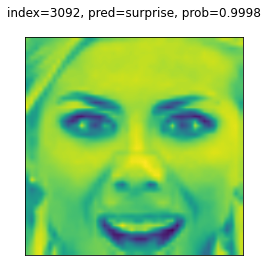

In [11]:
#display chosen image  - choose random or specific index function

# idx, example, label, prob = get_example_img()# gets a random image
idx, example, label, prob = get_specific_img(idx)  ## Use this line if you want a specific img

plt.imshow(example)
plt.tick_params(
    axis='both',          
    which='both',     
    bottom=False,
    left=False,
    labelleft=False,
    labelbottom=False)        
plt.title(f'index={idx}, pred={label}, prob={prob:.4f}\n')

In [12]:
import shap #import SHAP library

In [13]:
# extract the required tensor img from the testloader
from itertools import count
for img in zip(count(), iter(testloader)):
    index=img[0]
    if index==idx:
        break

In [14]:
idx, X, y = img[1]
X = X.float().to(device) # put to GPU for SHAP
y=y.to(device)

In [15]:
#create batch of imgs to sample against
batch_testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=False, num_workers=0, pin_memory = True, drop_last = True)
compare_idx, compare_X, compare_y = next(iter(batch_testloader)) 
imgs = compare_X.float().to(device) # put to GPU
test_imgs=X.float().to(device)

In [16]:
y_pred = net(test_imgs) # put the sample through the net
y_probs = torch.softmax(y_pred, 1) # get the prediction
true_idx = y[:].detach().cpu().numpy().item()
label_idx = torch.argmax(y_probs).detach().cpu().numpy() # get the prediction class name idx
y_pred = labels[0, label_idx] # get the prediction class name
true_label = labels[0, true_idx]
pred_prob = y_probs[0][label_idx].detach().cpu().numpy()
print('idx=', idx[:].detach().cpu().numpy().item())  #print sample image idx in case you want to come back to it
print('prediction=', y_pred)
print('true label=', true_label)
print('top prediction probability=', pred_prob)
print('all prediction probabilities=')

idx= 3092
prediction= surprise
true label= surprise
top prediction probability= 0.999782
all prediction probabilities=


In [17]:
#get class probability prediction order
probs = torch.topk(y_probs, y_probs.shape[1])[0].detach().cpu().numpy()
probs = probs.tolist()[0]
prob_order = torch.topk(y_probs, y_probs.shape[1])[1]
prob_order = prob_order.tolist()[0]
#change datatype and shap so it works with SHAP
single_dim_labels = labels.reshape(-1)
single_dim_labels = single_dim_labels[prob_order]
single_dim_labels = np.flip(single_dim_labels)
single_dim_labels
labels=np.array(single_dim_labels).reshape(1,7)

In [18]:
#get probs for each class prediction
zip_iterator = zip(list(reversed(single_dim_labels)), probs) 
prob_dict = dict(zip_iterator) 
prob_dict

{'surprise': 0.9997820258140564,
 'fear': 0.000124819329357706,
 'angry': 5.062219133833423e-05,
 'happy': 2.9250611987663433e-05,
 'neutral': 1.302223427046556e-05,
 'disgust': 3.863688391447795e-07,
 'sad': 3.376904977869799e-09}

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


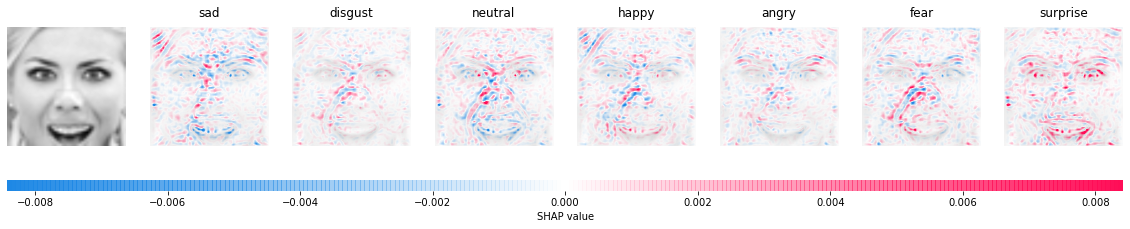

In [19]:
#create explainer object
#NB requires  lot of CUDA memory - may need to kill other notebooks and restart
#(see ref above, with adaptation to display in order or prediction probability)
e = shap.DeepExplainer(net, imgs)
shap_values = e.shap_values(test_imgs)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
shap_numpy = [shap_numpy[i] for i in np.flip(prob_order)] # reorder by probability (L-R)
test_numpy = np.swapaxes(np.swapaxes(test_imgs.detach().cpu().numpy(), 1, -1), 1, 2)

# plot the feature attributions with labels
shap.image_plot(shap_numpy, test_numpy, labels=labels, labelpad=10)

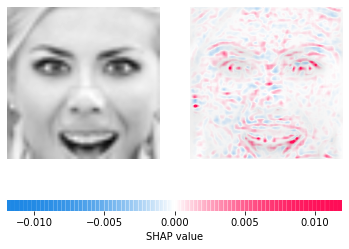

 original image           surprise SHAP values


In [20]:
#plot only the original image and values for predicted class
shap.image_plot(shap_numpy[6], test_numpy) #, labels=single_label, labelpad=10)
print(' original image          ',y_pred,'SHAP values')